<a href="https://colab.research.google.com/github/aoifekeane/EE475-Project/blob/main/binary_classifier_for_meter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classifier for Meter

This notebook trains and evaluates a binary classifier for meter data
The classifier distinguishes between jigs '0', and reels '1'

In [ ]:
import pandas as pd
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
filenmae = ""
df = pd.read_csv(r"/content/drive/MyDrive/project/data.csv")
meter = ['Jig', 'Reel']
filtered = df[df.Type.isin(meter)]

It is important to replace filename with the location of the .csv
- this filters the rows in the csv so that only jigs and reels are returned

In [ ]:
l = filtered['Type']
i =0
y =  np.empty(len(l), dtype = float)
for t in l:
  if t == 'Jig':
    y[i] = 0
  elif t =="Reel":
    y[i] = 1
  i= i+1
print(len(l))
print(len(y))

246
246


- This labels jig with 0 and reels with 1

In [ ]:
batch = len(y)
train =round(batch*0.7)
test = batch -train

- gets values for a 70:30 train:test split

In [ ]:
source = ""  + filtered['Track']
x = np.empty((batch, 384, 862), dtype = float)
hop_length = 256
i = 0;
for f in source:
    a, sr = librosa.load(f, duration = 10)
    oenv = librosa.onset.onset_strength(y=a, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
    x[i] = tempogram
    print(i, "/", batch)
    i= i+1
    


It is important to change the value of source to where the music files for this data are stored
- This block of code filters the audio tracks again to onlt contain jigs and reels
- the first 10 seconds of audio are read from each file
- librosa is used to convert this into a tempogram, using an onset envelope and a hop length of 256
- each tempogram is stored as an array, and each array is appended to the list of inputs x

In [ ]:
x_train = x[0:train]
x_test = x[train:batch]
y_train = y[0:train]
y_test = y[train:batch]

This block of code splits the input and output data into train and test batches

In [ ]:
rx_train = x_train.reshape((train,384, 862,1))
ry_train = y_train.reshape((train,1))

rx_test = x_test.reshape((test,384, 862,1))
ry_test = y_test.reshape((test,1))


In order to be input into the CNN, the data must be reshaped to account for the size of the inputs and that the data is not an image and thus only has one colour channel

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
inputs = rx_train
targets = ry_train
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (4, 1), activation='relu', input_shape=(384, 862,1), data_format='channels_last', padding="same"))
  model.add(layers.MaxPooling2D((2, 2)))
  #added dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (4, 1), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #added dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (4, 1), activation='relu', padding="same"))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(inputs[train], targets[train], 
                    epochs=10, validation_data = (rx_test,ry_test))
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  predicted_categories = model.predict_classes(inputs[test])
  true_categories = tf.concat(targets[test], axis=0)
  array = confusion_matrix(predicted_categories, true_categories, normalize=None)
  df_cm = pd.DataFrame(array, index = [i for i in ['Jig', 'Reel']],
                    columns = [i for i in ['Jig', 'Reel']])
  plt.figure(figsize = (10,7))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  sn.heatmap(df_cm, annot=True)
  fname = '/content/drive/MyDrive/project/bin class models/tempogram_model'+str(fold_no)
  model.save(fname)
  # Increase fold number
  fold_no = fold_no + 1

- performs 5-fold cross validation on different combinations of inputs
- the model created is a CNN with:
  -  3 2D convolutional layers
  - 2 max pooling layers
  - 2 instances of 20% dropout
- the model is compiled with the adam optimiser and loss as binary cross entropy
- each fold of cross validation is assessed through the use of a confusion matrix
- each fold's model is saved so that the model that performs the best can be trained on all the data

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/project/bin class models/tempogram_model5')

the best performing model is loaded in

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
 
  def on_epoch_end(self, epoch, logs={}):
    validation_data = (rx_test,ry_test)
    val_predict = (np.asarray(self.model.predict(validation_data[0]))).round()
    val_targ = validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
    return
 
metrics = Metrics() 

These are metrics that record the validation precision, recall and f-measure (also called f1 score).
these are logged every epoch so we can get a visualisation on how the model performs over time

In [ ]:
history = model.fit(x = rx_train, y=ry_train,
                    epochs=10, validation_data = (rx_test,ry_test), callbacks=[metrics])

model is trained on the whole training set for 10 epochs

Score for model: loss of 0.6728682518005371; accuracy of 91.89189076423645%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


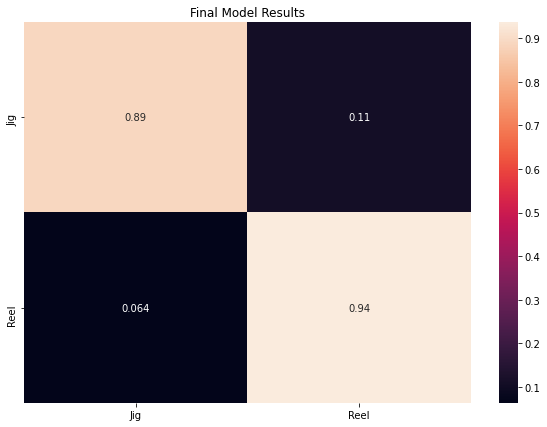

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

scores = model.evaluate(rx_test, ry_test, verbose=0)
print(f'Score for model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

predicted_categories = model.predict_classes(rx_test)
true_categories = tf.concat(ry_test, axis=0)
array = confusion_matrix(predicted_categories, true_categories, normalize='true')
df_cm = pd.DataFrame(array, index = [i for i in ['Jig', 'Reel']],
                  columns = [i for i in ['Jig', 'Reel']])
plt.figure(figsize = (10,7))
plt.title('Final Model Results')
plt.xlabel('Predicted')
plt.ylabel('True')
sn.heatmap(df_cm, annot=True)

The model is evaluated on the test data and the confusion matrix is plotted to view how the model responds to classifying each class

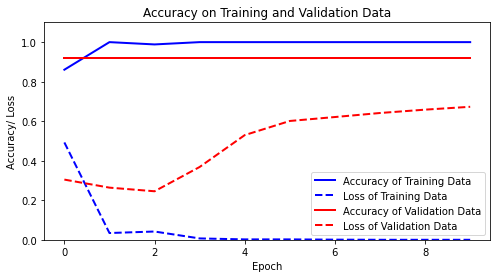

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(history.history['accuracy'], label='Accuracy of Training Data', color='blue', linewidth=2)
plt.plot(history.history['loss'], label='Loss of Training Data', color='blue', linewidth=2, linestyle='dashed')
plt.plot(history.history['val_accuracy'], label = 'Accuracy of Validation Data',color='red', linewidth=2)
plt.plot(history.history['val_loss'], label = 'Loss of Validation Data',color='red', linewidth=2, linestyle='dashed')
plt.title('Accuracy on Training and Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/ Loss')
plt.ylim([0, 1.1])
plt.legend()

The training and validation accuracies and loss are plotted per epoch 

3/3 - 0s - loss: 0.6729 - accuracy: 0.9189


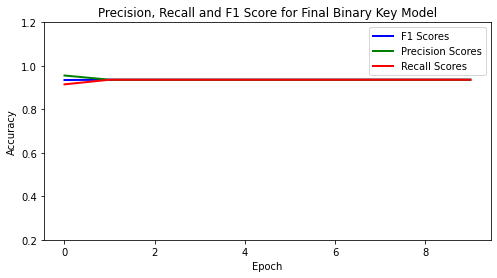

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(metrics.val_f1s, label = 'F1 Scores',color='blue', linewidth=2)
plt.plot(metrics.val_precisions, label = 'Precision Scores',color='green', linewidth=2)
plt.plot(metrics.val_recalls, label = 'Recall Scores',color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precision, Recall and F1 Score for Final Binary Key Model')
plt.ylim([0.2, 1.2])
plt.legend()
test_loss, test_acc = model.evaluate(rx_test,  ry_test, verbose=2)

The precision, recall and f-measure are plotted per epoch

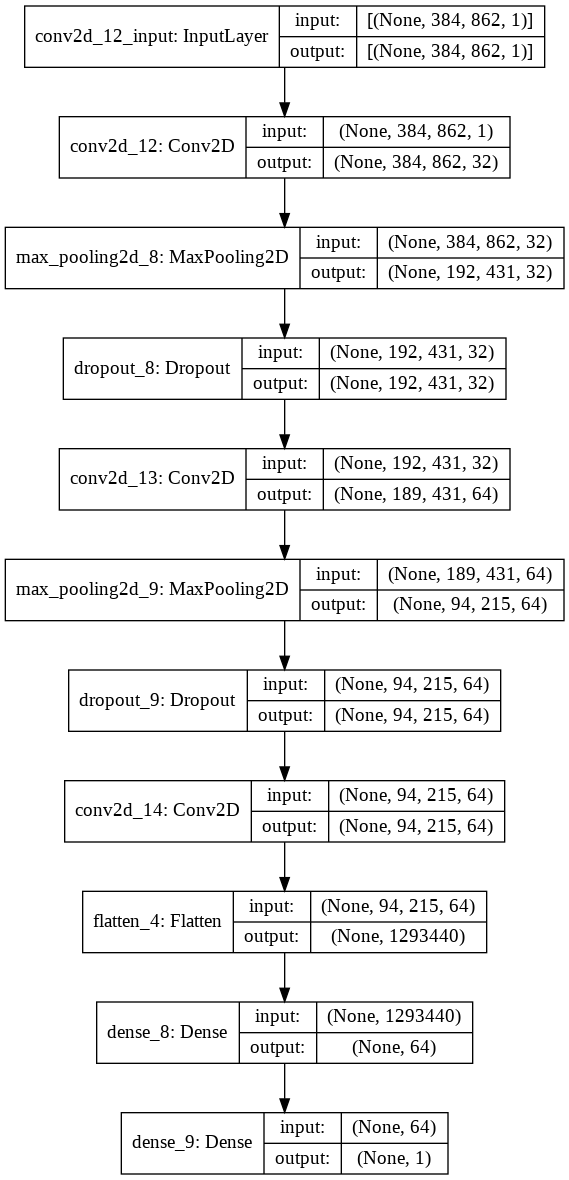

In [ ]:
from keras.utils.vis_utils import plot_model
from PIL import Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
display(Image.open('model.png'))